In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (421 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [ ]:
from google.colab import drive
import faiss

In [ ]:
from tqdm import tqdm
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import glob
import ntpath
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import io
import bson
import matplotlib.pyplot as plt
from skimage.io import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
from PIL import Image

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/Chocz/sampleimages.zip' -d '/content/images/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/sampleimages/1000010562_168146_1.jpeg  
  inflating: /content/images/sampleimages/1000010562_168146_2.jpeg  
  inflating: /content/images/sampleimages/1000010562_168146_3.jpeg  
  inflating: /content/images/sampleimages/1000010562_168146_4.jpeg  
  inflating: /content/images/sampleimages/1000010562_204480_1.jpeg  
  inflating: /content/images/sampleimages/1000010562_204480_2.jpeg  
  inflating: /content/images/sampleimages/1000010562_204480_3.jpeg  
  inflating: /content/images/sampleimages/1000010562_204480_4.jpeg  
  inflating: /content/images/sampleimages/1000010562_212334_1.jpeg  
  inflating: /content/images/sampleimages/1000010562_212334_2.jpeg  
  inflating: /content/images/sampleimages/1000010562_214433_1.jpeg  
  inflating: /content/images/sampleimages/1000010562_214433_2.jpeg  
  inflating: /content/images/sampleimages/1000010562_214433_3.jpeg  
  inflating: /content/images/sampleimages/1000010562

In [ ]:
import glob
image_paths = glob.glob('/content/images/sampleimages/*.jpeg')
print(f'Founnd {len(image_paths)} images')

Founnd 9191 images


In [ ]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
            if len(file_list)>2000:
              break
    return file_list
root_dir = '/content/images/sampleimages/'
filenames = sorted(get_file_list(root_dir))

In [ ]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
len(feature_list)

2001

In [ ]:
features=np.array(feature_list)
features.shape

(2001, 100352)

In [ ]:
dimensions=features.shape[1]
db_vectors=features 
nlist = 5  
quantiser = faiss.IndexFlatL2(dimensions)  
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) 


In [ ]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

False
0
True
2001


In [ ]:
nprobe = 2  
n_query = 1  
k = 10  
np.random.seed(0)   
distances, indices = index.search(feature_list[23].reshape(1,-1), k)

In [ ]:
distances

array([[0.       , 0.9902562, 0.9910807, 1.0208988, 1.0316238, 1.1283746,
        1.1328878, 1.1557453, 1.1707573, 1.1755098]], dtype=float32)

In [ ]:
indices

array([[  23, 1110,  356, 1590,  351, 1271,  906,  286,  715, 1602]])

In [ ]:
feature_list[1].reshape(1,-1).shape

(1, 100352)

In [ ]:
list_ind=indices.flatten().tolist()


In [ ]:
list_ind

[23, 1110, 356, 1590, 351, 1271, 906, 286, 715, 1602]

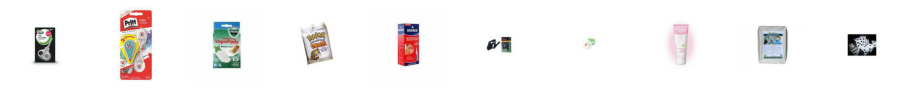

In [ ]:
f, ax = plt.subplots(1, 10, figsize=(16, 8))
for i,j in enumerate(list_ind):
  ax[i].imshow(plt.imread(filenames[j]))
  ax[i].set_axis_off()

plt.show()

In [ ]:
def faiss_similarity(img):
  feature_list=extract_features('/content/images/sampleimages/'+str(img), model)
  nprobe = 2  
  n_query = 1  
  print(feature_list)
  k = 10   
  np.random.seed(0)
  dimensions=len(feature_list)   
  query_vectors = np.random.random((n_query, dimensions)).astype('float32')
  distances, indices = index.search(feature_list.reshape(1,-1), k)
  list_ind=indices.flatten().tolist()
  f, ax = plt.subplots(1, 10, figsize=(16, 8))
  for i,j in enumerate(list_ind):
    ax[i].imshow(plt.imread(filenames[j]))
    ax[i].set_axis_off()
  plt.show()

[0.         0.         0.         ... 0.00426079 0.         0.        ]


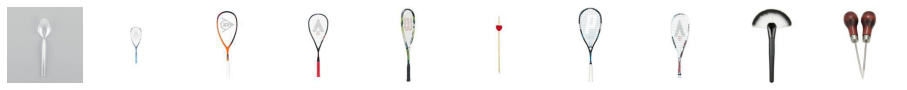

In [ ]:
faiss_similarity('1000020743_1884436_1.jpeg')